# Lexical network analysis (1)

## Loading

In [3]:
### Initialisation of the absolute Github repository path :

from pathlib import Path
import sys

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


### Import data prepared
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(f"Data preparation folder detected at: {DATA_PREPARATION_PY_PATH.resolve()}")

Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
Data preparation folder detected at: C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


In [4]:
# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle


# classic librairies
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# text processing librairies
from sklearn.feature_extraction.text import CountVectorizer

# statistical libraries
import networkx as nx


In [5]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)


### Loading of preprocessed data's pickle :
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

dataA_lem = lemmatized_data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

## Lexical network out of the captions

In [6]:
contest_idx = contest_index2absolute_index(611)

if contest_idx > dataC_lastGoodID:
    print(f"Attention, il n'y a pas de metadonnée pour le contest {contest_idx} !")

<br/><br/>
<center>
    <img src="../../data/newyorker_caption_contest_virgin/images/611.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

In [7]:
dataA_lem[contest_idx].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,cleaned_caption
rank,,,,,,,,
0,"Believe me, I’ve tested a lot worse things whe...",1.878577,0.010817,5452,2110,1894,1448,believe tested lot worse thing pharmaceutical
1,"If he can be President, I can fly.",1.847732,0.010908,5799,2509,1664,1626,president fly
2,"""Fine, but for our second date you are coming ...",1.838001,0.010525,5642,2294,1968,1380,fine second date coming fewer grafting
3,"Okay, just one more time to clarify...statues ...",1.835086,0.011619,4754,1982,1574,1198,okay one time clarifystatues worth newly washe...
4,I don't know Mom. I'm starting to think maybe ...,1.834064,0.011259,4791,1918,1750,1123,know mon starting think maybe adopted


Observations :
> contest 801:\
Taxes ? why do they talk about taxes and why is it funny ?\
grim loser ?\
Leonard ?


> contest 661:

In [8]:
# Build the (basic) lexical network

def build_lexical_network(caption_list):
    """
    Build a lexical network based on co-occurrence of words in captions.
    """
    # Tokenize: split each caption into words
    tokenized_captions = [c.split() for c in caption_list if isinstance(c, str) and c.strip()]

    # Build co-occurrence matrix
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    X = vectorizer.fit_transform(tokenized_captions)
    vocab = vectorizer.get_feature_names_out()

    cooccurrence = (X.T @ X).toarray()  # co-occurrence count matrix
    np.fill_diagonal(cooccurrence, 0)  # remove self-loops

    # Build graph
    G = nx.Graph()
    for i, word1 in enumerate(vocab):
        for j, word2 in enumerate(vocab):
            if cooccurrence[i, j] > 0:
                G.add_edge(word1, word2, weight=cooccurrence[i, j])
    
    return G

def plot_lexical_network(G, top_n=30):
    """
    Plot the lexical network, optionally focusing on top_n nodes by degree.
    """
    # Select top_n nodes by degree
    degrees = dict(G.degree(weight='weight'))
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)

    pos = nx.spring_layout(H, seed=42, k=0.5, iterations=50)
    
    # Node sizes proportional to weighted degree
    sizes = [degrees[n]*10 for n in H.nodes()]
    
    # Edge widths proportional to co-occurrence
    weights = [H[u][v]['weight']/5 for u,v in H.edges()]

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(H, pos, width=weights, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')
    
    plt.title("Lexical Network of Captions (Top Words by Co-occurrence)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


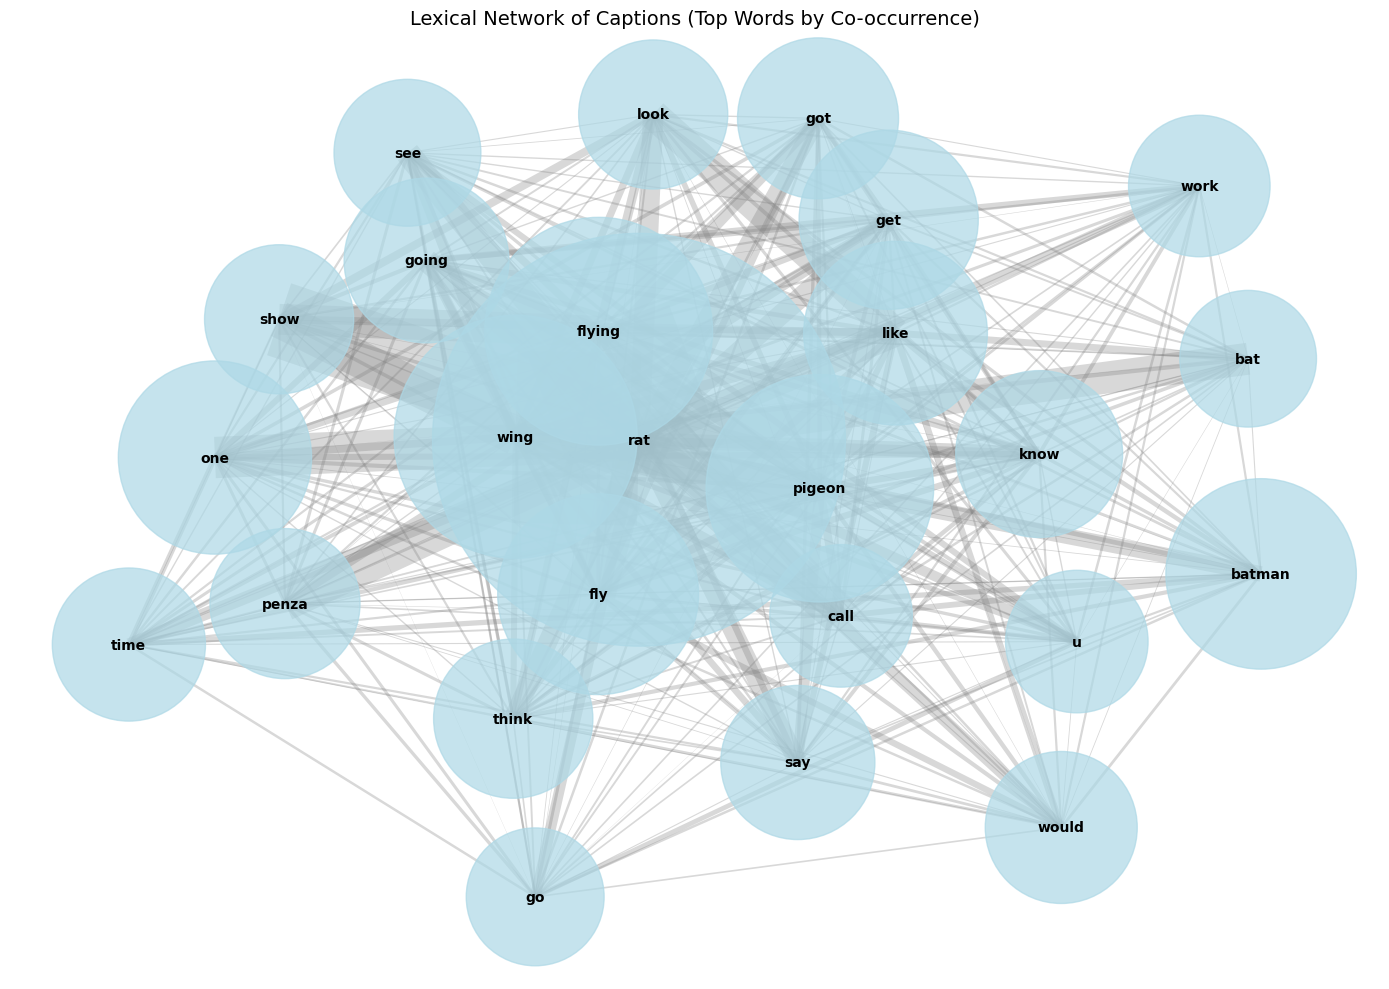

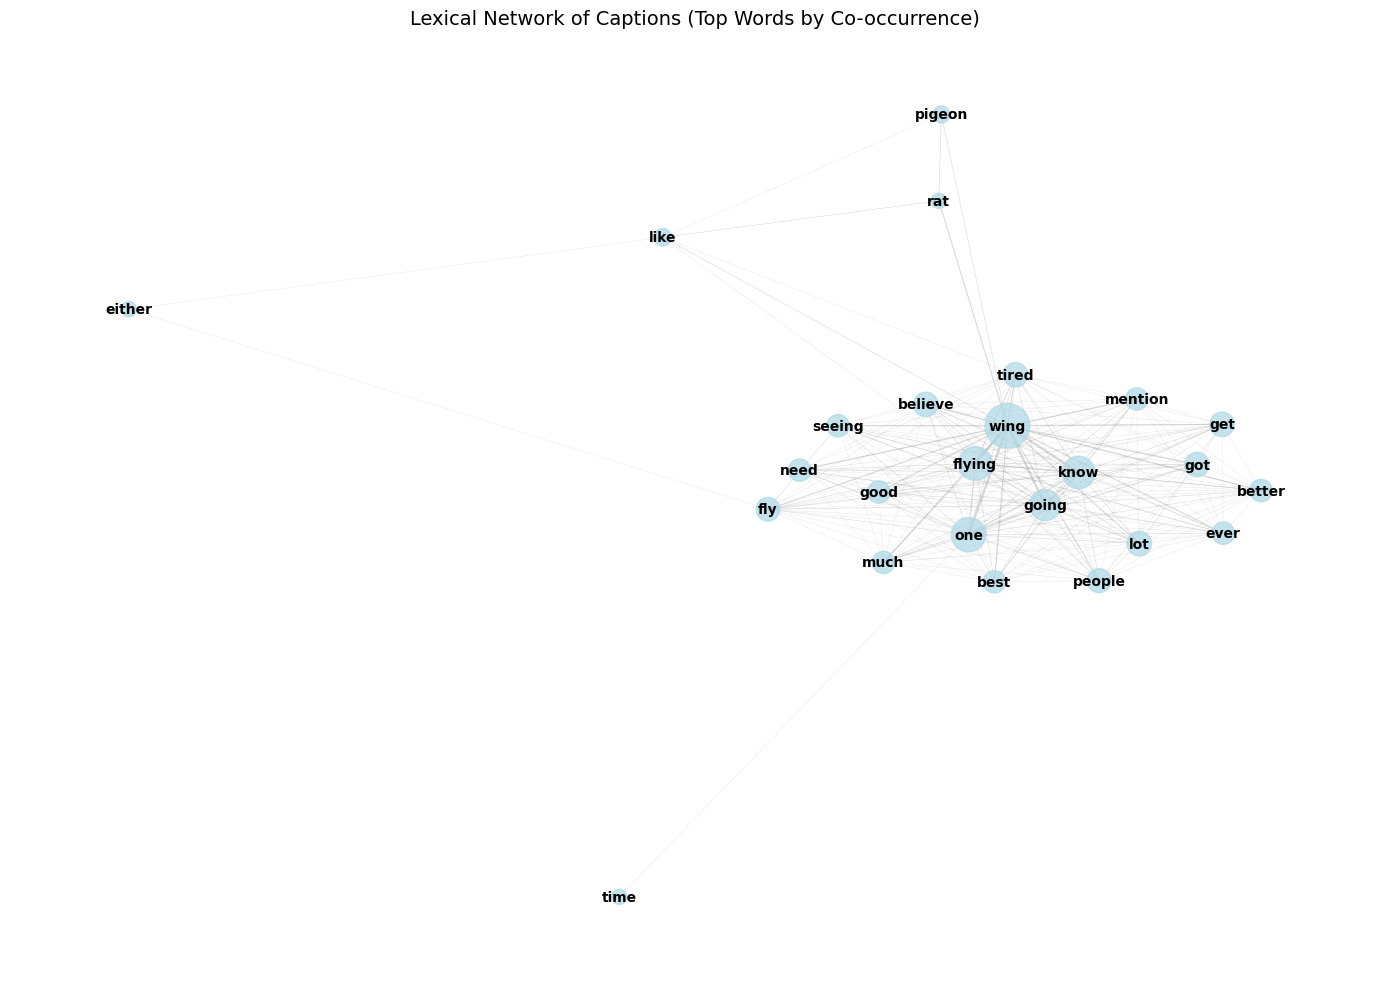

In [9]:
# pour un seul contest:
captions = dataA_lem[contest_idx]['cleaned_caption'].tolist()
G = build_lexical_network(captions)
plot_lexical_network(G, top_n=25)

# les 25 meilleurs de ce contest:
captions = dataA_lem[contest_idx]['cleaned_caption'][:25].tolist()
G = build_lexical_network(captions)
plot_lexical_network(G, top_n=25)

In [67]:
# Build the TF-IDF network

from sklearn.feature_extraction.text import TfidfVectorizer

def build_lexical_network_tfidf(caption_list, average_coocurence_tfidf=True, idf_weight=0.5, min_tfidf=0.0):
    """
    Build a lexical network based on co-occurrence of words weighted by TF-IDF.
    
    Parameters:
    -----------
    caption_list : list
        List of captions (strings with space-separated words)
    idf_weight : float (0 to 1)
        How much to weight IDF vs raw co-occurrence. 
        0 = only co-occurrence, 1 = only TF-IDF
    min_tfidf : float
        Minimum TF-IDF score for a word to be included in the network
    """
    # Tokenize: split each caption into words
    tokenized_captions = [c.split() for c in caption_list if isinstance(c, str) and c.strip()]
    
    # Join back for TF-IDF (it expects strings)
    caption_strings = [' '.join(tokens) for tokens in tokenized_captions]

    # Build TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x.split(),
        lowercase=False,
        encoding="utf-8",

        preprocessor=None,
        stop_words= None,
        token_pattern= r"(?u)\b\w\w+\b",
        norm= "l2",
        )

    
    X_tfidf = tfidf_vectorizer.fit_transform(caption_strings)
    vocab = tfidf_vectorizer.get_feature_names_out()

    
    # Get IDF scores for each word
    idf_scores = dict(zip(vocab, tfidf_vectorizer.idf_))
    
    # Build co-occurrence matrix (raw counts)
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
    X_count = count_vectorizer.fit_transform(caption_strings)

    # nombre de fois que le mot i et le mot j apparaissent ensemble dans les mêmes documents
    cooccurrence = (X_count.T @ X_count).toarray()
    np.fill_diagonal(cooccurrence, 0)
    
    # Calculate mean TF-IDF score for each word across all documents
    mean_tfidf = np.array(X_tfidf.mean(axis=0)).flatten()
    word_tfidf_scores = dict(zip(vocab, mean_tfidf))
    
    # Build graph with weighted edges
    G = nx.Graph()
    
    for i, word1 in enumerate(vocab):
        # Filter out words with low TF-IDF
        if word_tfidf_scores[word1] < min_tfidf:
            continue
        for j, word2 in enumerate(vocab):
            if i >= j:  # Avoid duplicates and self-loops
                continue
            if word_tfidf_scores[word2] < min_tfidf:
                continue
            
            if cooccurrence[i, j] > 0:
                # Weight edge by co-occurrence AND average IDF of the two words
                raw_cooccurrence = cooccurrence[i, j]


                if average_coocurence_tfidf:
                    avg_idf = (idf_scores[word1] + idf_scores[word2]) / 2
                    
                    # Combine co-occurrence with IDF weighting
                    weighted_score = (1 - idf_weight) * raw_cooccurrence + idf_weight * raw_cooccurrence * avg_idf
                    G.add_edge(word1, word2, 
                        weight=weighted_score,
                        raw_cooccurrence=raw_cooccurrence,
                        avg_idf=avg_idf)

                else:
                    prod_idf = idf_scores[word1] * idf_scores[word2]
                    
                    # Simple product IDF weighting
                    weighted_score = raw_cooccurrence * prod_idf
                    G.add_edge(word1, word2, 
                            weight=weighted_score,
                            raw_cooccurrence=raw_cooccurrence,
                            prod_idf=prod_idf)
    
    # Add node attributes (TF-IDF scores)
    nx.set_node_attributes(G, word_tfidf_scores, 'tfidf')
    nx.set_node_attributes(G, idf_scores, 'idf')
    
    return G



import matplotlib.lines as mlines
def plot_lexical_network_tfidf(G, top_n=30, size_metric='tfidf'):
    """
    Plot the lexical network, focusing on top_n nodes.
    """

    # ---- Node metrics for sizing ----
    if size_metric == 'tfidf':
        scores = nx.get_node_attributes(G, 'tfidf')
        size_label = "TF-IDF"
    elif size_metric == 'idf':
        scores = nx.get_node_attributes(G, 'idf')
        size_label = "IDF"
    else:
        scores = dict(G.degree(weight='weight'))
        size_label = "Degree"

    # ---- Select top nodes ----
    top_nodes = sorted(scores, key=scores.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)

    if len(H.nodes()) == 0:
        print("No nodes to display")
        return

    # ---- Layout ----
    pos = nx.spring_layout(H, seed=42, k=0.5, iterations=50)

    # ---- Node sizes ----
    sizes = [scores[n] * 100000 for n in H.nodes()]

    # ---- Edge widths ----
    edge_weights = [d['weight'] for _, _, d in H.edges(data=True)]
    if len(edge_weights) > 0:
        weight_scale = max(1, np.percentile(edge_weights, 75))
        widths = [d['weight'] / weight_scale for _, _, d in H.edges(data=True)]
    else:
        widths = 1

    # ---- Node colors (IDF) ----
    idf_values = [nx.get_node_attributes(G, 'idf').get(n, 1) for n in H.nodes()]

    # ---- Plot ----
    plt.figure(figsize=(14, 10))

    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_size=sizes,
        node_color=idf_values,
        cmap='YlOrRd',
        alpha=0.75,
        vmin=min(idf_values),
        vmax=max(idf_values)
    )

    nx.draw_networkx_edges(H, pos, width=widths, alpha=0.35, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')

    plt.colorbar(nodes, label="IDF Score (Discriminative Power)", shrink=0.8)
    legend_handles = [
        mlines.Line2D([], [], color='gray', marker='o', alpha=0.3, linestyle='None',
                      markersize=np.sqrt(300), label=f"Low {size_label}"),
        mlines.Line2D([], [], color='gray', marker='o', alpha=0.3, linestyle='None',
                      markersize=np.sqrt(900), label=f"Medium {size_label}"),
        mlines.Line2D([], [], color='gray', marker='o', alpha=0.3, linestyle='None',
                      markersize=np.sqrt(1800), label=f"High {size_label}")
    ]
    plt.legend(handles=legend_handles, loc="best", fontsize=11, title_fontsize=12)

    plt.title(f"Lexical Network of Captions\nTop {top_n} Words by {size_metric.upper()}", fontsize=16, pad=15)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return top_nodes


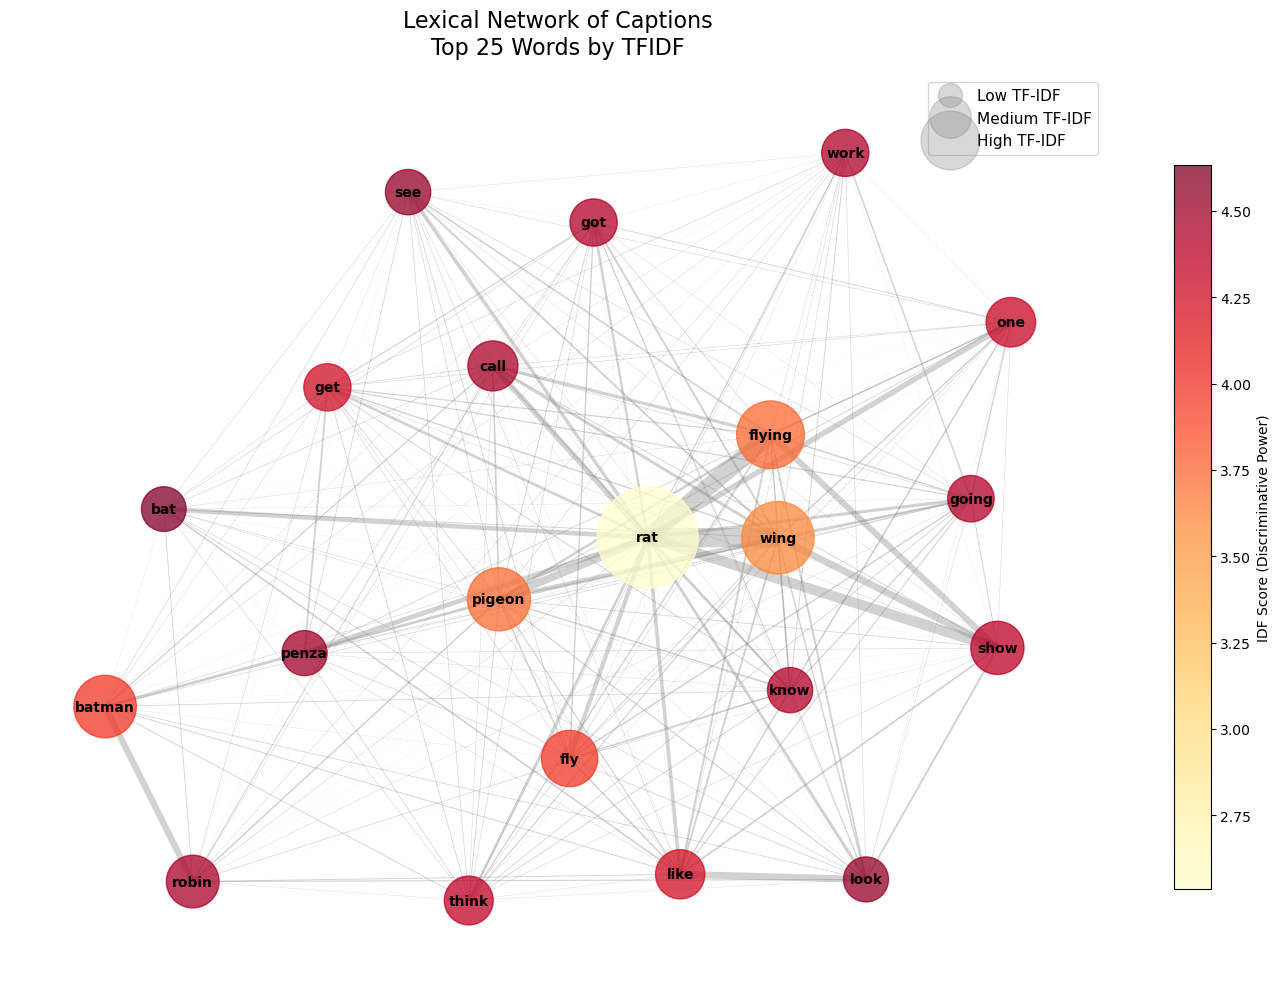

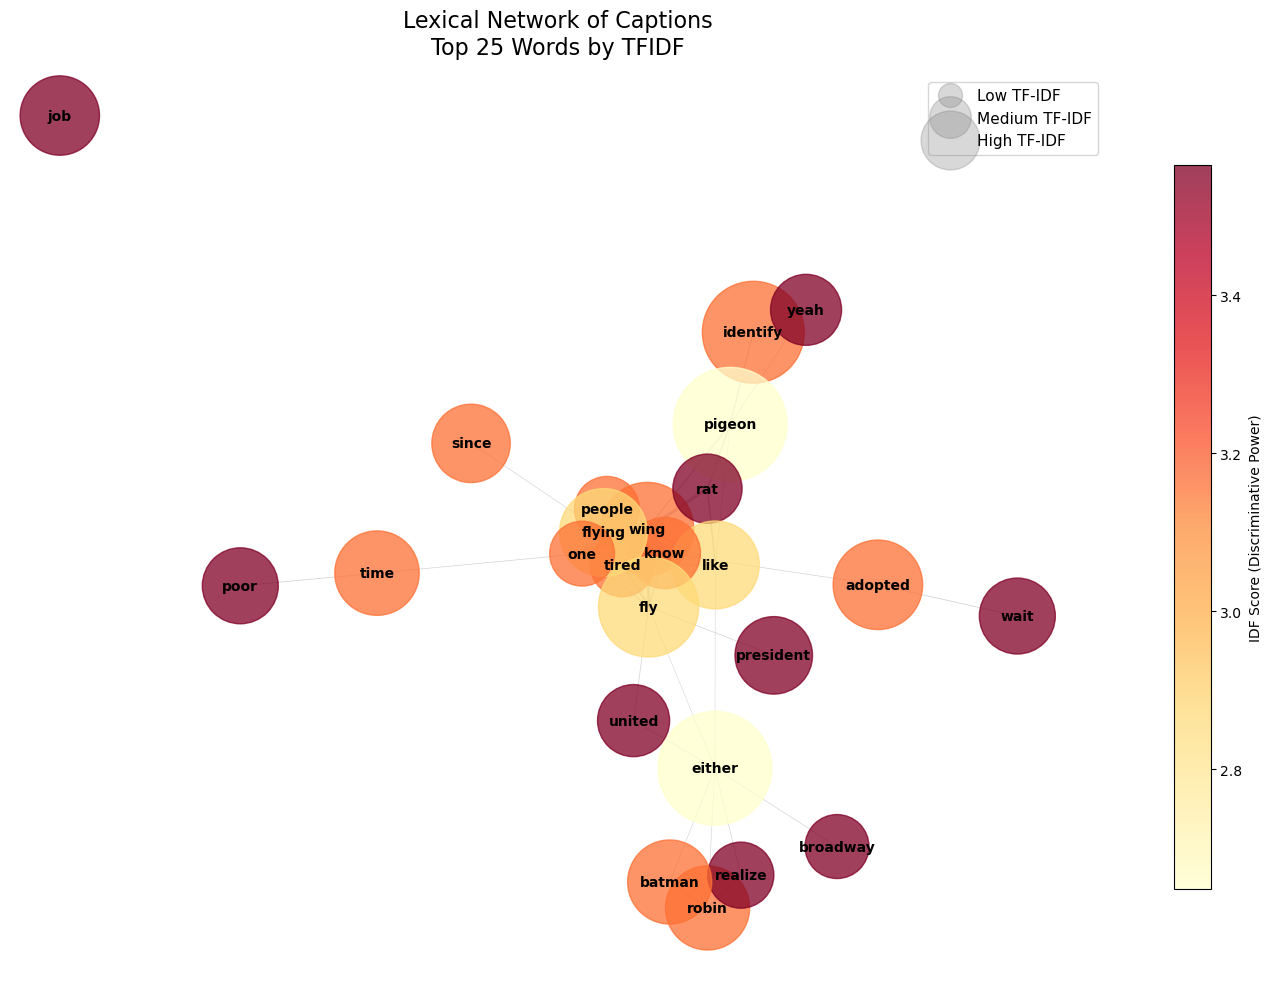

In [68]:
### pour un seul contest:
captions = dataA_lem[contest_idx]['cleaned_caption'].tolist()
# Plus de poids sur IDF (mots discriminants)
G_idf_heavy = build_lexical_network_tfidf(captions, average_coocurence_tfidf=False, idf_weight=1, min_tfidf=0.01)
top_tfidf_nodes_all = plot_lexical_network_tfidf(G_idf_heavy, size_metric='tfidf', top_n=25)



### les 25 meilleurs de ce contest:
captions = dataA_lem[contest_idx]['cleaned_caption'][:25].tolist()
# Plus de poids sur IDF (mots discriminants)
G_idf_heavy = build_lexical_network_tfidf(captions, average_coocurence_tfidf=False, idf_weight=1, min_tfidf=0.01)
top_tfidf_nodes_top25 = plot_lexical_network_tfidf(G_idf_heavy, size_metric='tfidf', top_n=25)

In [30]:
print(top_tfidf_nodes_all)
print(top_tfidf_nodes_top25)

differences = {"top25_different_words" : list(set(top_tfidf_nodes_top25) - set(top_tfidf_nodes_all))}

differences_df = pd.DataFrame(differences)

display(differences_df)

['rat', 'wing', 'flying', 'pigeon', 'batman', 'fly', 'show', 'robin', 'call', 'one', 'like', 'think', 'get', 'got', 'work', 'going', 'see', 'know', 'penza', 'look', 'bat']
['either', 'pigeon', 'identify', 'fly', 'wing', 'adopted', 'like', 'flying', 'time', 'batman', 'robin', 'job', 'since', 'president', 'wait', 'poor', 'united', 'know', 'yeah', 'rat', 'realize', 'people', 'one', 'tired', 'broadway']


,top25_different_words
0,job
1,either
2,president
3,tired
4,people
5,broadway
6,identify
7,adopted
8,realize
9,since


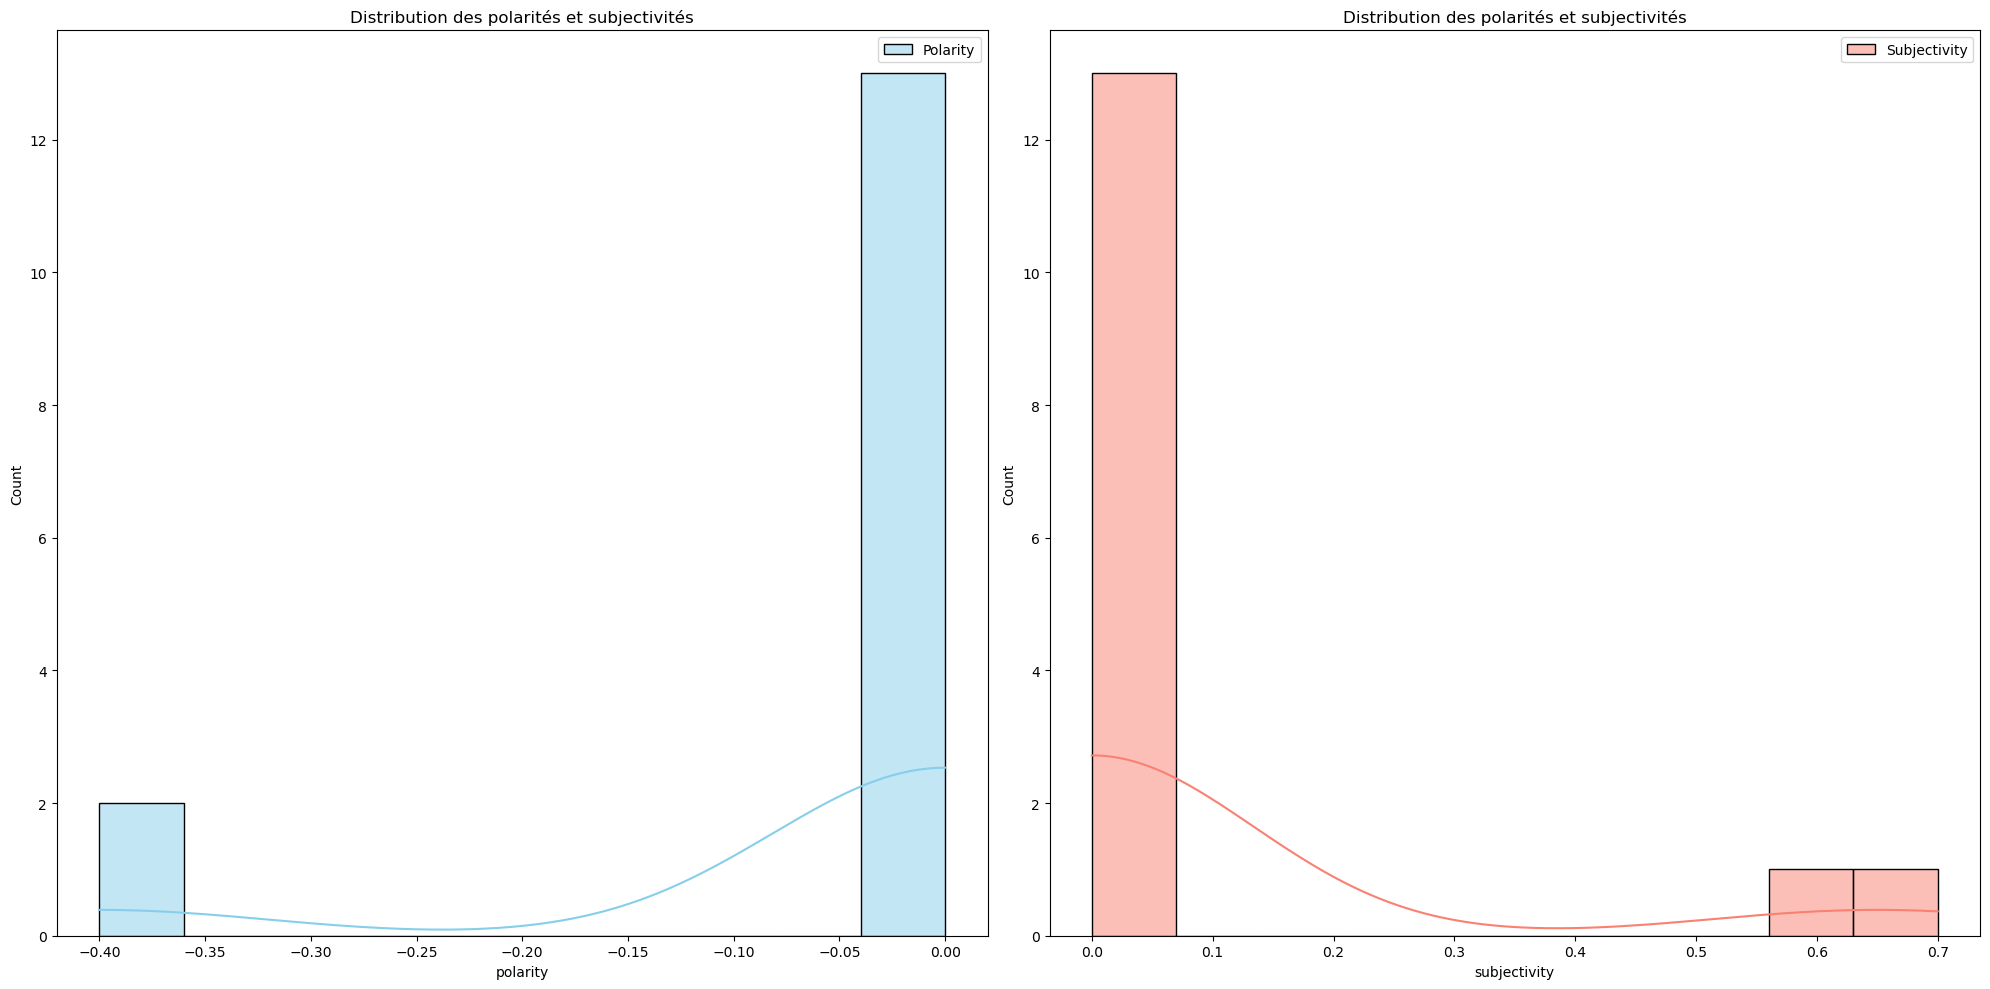

In [31]:
from textblob import TextBlob

results_blob = []

for cap in differences_df["top25_different_words"]:
    blob = TextBlob(cap)
    results_blob.append(
        {
        'caption': cap,
        'tags': blob.tags,
        'nouns': blob.noun_phrases,
        'verbs': [word.lower() for word, pos in blob.tags if pos.startswith("VB")],
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    }
    )

# Convertir en DataFrame pour analyses
df_blob = pd.DataFrame(results_blob)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot top network
plt.sca(axes[0])
sns.histplot(df_blob['polarity'], bins=10, kde=True, color='skyblue', label='Polarity')
plt.title(f"Distribution des polarités et subjectivités")
plt.legend()

# Plot rest network
plt.sca(axes[1])
sns.histplot(df_blob['subjectivity'], bins=10, kde=True, color='salmon', label='Subjectivity')
plt.title(f"Distribution des polarités et subjectivités")
plt.legend()

plt.tight_layout()
plt.show()

## Voir si le lexical network ressemble à la description, uncanny description, wikipedia links correspondants

In [ ]:
def extract_wiki_titles(entity_list):
    return [
        url.split("wikipedia.org/wiki/")[1]
        for url in entity_list
        if "wikipedia.org/wiki/" in url
    ]

In [ ]:
img_description = dataC.iloc[contest_idx].image_descriptions
img_uncanny_description = dataC.iloc[contest_idx].image_uncanny_descriptions

wiki_titles = extract_wiki_titles(dataC.iloc[contest_idx].entities)


print(f"img_description : {img_description}\nimg_uncanny_description : {img_uncanny_description}\nwikipedia : {wiki_titles}")

img_description : ['A rat and a pigeon are on a roof in a city. The rate has wings strapped to him.']
img_uncanny_description : ['A rat with fake wings is pretty out of place.']
wikipedia : ['Domestic_pigeon', 'Rat']


## et entre tous les contests ?